# 3D QLIPP reconstruction with experimental data
This reconstruction is based on the QLIPP paper ([here](https://elifesciences.org/articles/55502)): <br>
``` S.-M. Guo, L.-H. Yeh, J. Folkesson, I. E. Ivanov, A. P. Krishnan, M. G. Keefe, E. Hashemi, D. Shin, B. B. Chhun, N. H. Cho, M. D. Leonetti, M. H. Han, T. J. Nowakowski, S. B. Mehta , "Revealing architectural order with quantitative label-free imaging and deep learning," eLife 9:e55502 (2020).```

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"


import glob

from skimage import io

import waveorder as wo

%matplotlib inline
plt.style.use(["dark_background"])  # Plotting option for dark background

### Experiment parameters

In [18]:
n_media = 1.512  # refractive index of the immersion media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu = 0.532  # illumination wavelength (um)
mag = 63  # magnification of the microscope
NA_obj = 1.47  # detection NA of the objective
NA_illu = 0.9  # illumination NA of the condenser
N_defocus = 45  # number of defocus images
N_channel = 5  # number of Polscope channels
z_step = 0.25  # z_step of the stack
z_defocus = -(np.r_[:N_defocus] - N_defocus // 2) * z_step
pad_z = 5  # padding in the z-dimension
chi = 0.1 * 2 * np.pi  # swing of the LC
ps = 6.45 / mag  # effective pixel size at the sample plane (cam pix/mag in um)
cali = True  # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option = "local_fit"  # background correction method for Polscope recon (does not affect phase)
topdir = "/Volumes/comp_micro/rawdata"  # top directory of the data
data_path = (
    topdir + "/dragonfly/virtualstaining/2019_02_15_kidney_slice/SMS_2018_1227_1433_1/2-Pos_007_025/"
)  # data path
bg_path = (
    topdir + "/dragonfly/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/"
)  # background data path
use_gpu = True
gpu_id = 0

In [19]:
filedir = data_path + "*PolState*.tif"
filedir_bg = bg_path + "*State*.tif"
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)
files_bg

['/Volumes/comp_micro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/img_000000000_State0 - Acquired Image_000.tif',
 '/Volumes/comp_micro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/img_000000000_State1 - Acquired Image_000.tif',
 '/Volumes/comp_micro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/img_000000000_State2 - Acquired Image_000.tif',
 '/Volumes/comp_micro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/img_000000000_State3 - Acquired Image_000.tif',
 '/Volumes/comp_micro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/img_000000000_State4 - Acquired Image_000.tif']

In [41]:
# select a FOV for processing

Ns = 500
Ms = 500
n_start = [500, 1350]

plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(files[44 + 22]).astype("float64")[n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms])

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/comp_micro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/SMS_2018_1227_1433_1/2-Pos_007_025/img_000000000_Zyla_PolState1_Widefield_021.tif'

<Figure size 1000x1000 with 0 Axes>

### Load data

In [23]:
# Load files

Nimg = N_defocus * N_channel

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype("float64")[n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

I_meas_pre = []

for i in range(0, Nimg):
    Itemp = io.imread(files[i]).astype("float64")[n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms]
    I_meas_pre.append(Itemp)

I_meas_pre = np.array(I_meas_pre)
I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0, 2, 3, 1))

# intensity mapping to match the theory
I_meas = np.zeros_like(I_meas_pre)
for i in range(N_defocus):
    I_meas[:, :, :, i] = wo.intensity_mapping(I_meas_pre[:, :, :, i])

In [29]:
wo.parallel_4D_viewer(np.transpose(I_meas, (3, 0, 1, 2)), num_col=3, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### Polarization reconstruction

In [31]:
# Reconstruct parameters

setup = wo.waveorder_microscopy(
    (Ns, Ms),
    lambda_illu,
    ps,
    NA_obj,
    NA_illu,
    z_defocus,
    chi,
    n_media=n_media,
    cali=cali,
    bg_option=bg_option,
    bire_in_plane_deconv="3D",
    phase_deconv="3D",
    pad_z=pad_z,
    use_gpu=False,
    gpu_id=gpu_id,
)

In [32]:
S_image_recon = setup.Stokes_recon(I_meas)
S_bg_recon = setup.Stokes_recon(I_bg)
S_image_tm = setup.Stokes_transform(S_image_recon)
S_bg_tm = setup.Stokes_transform(S_bg_recon)
S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm)
Recon_para = setup.Polarization_recon(S_image_tm)

In [35]:
wo.parallel_4D_viewer(np.transpose(Recon_para, (3, 0, 1, 2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

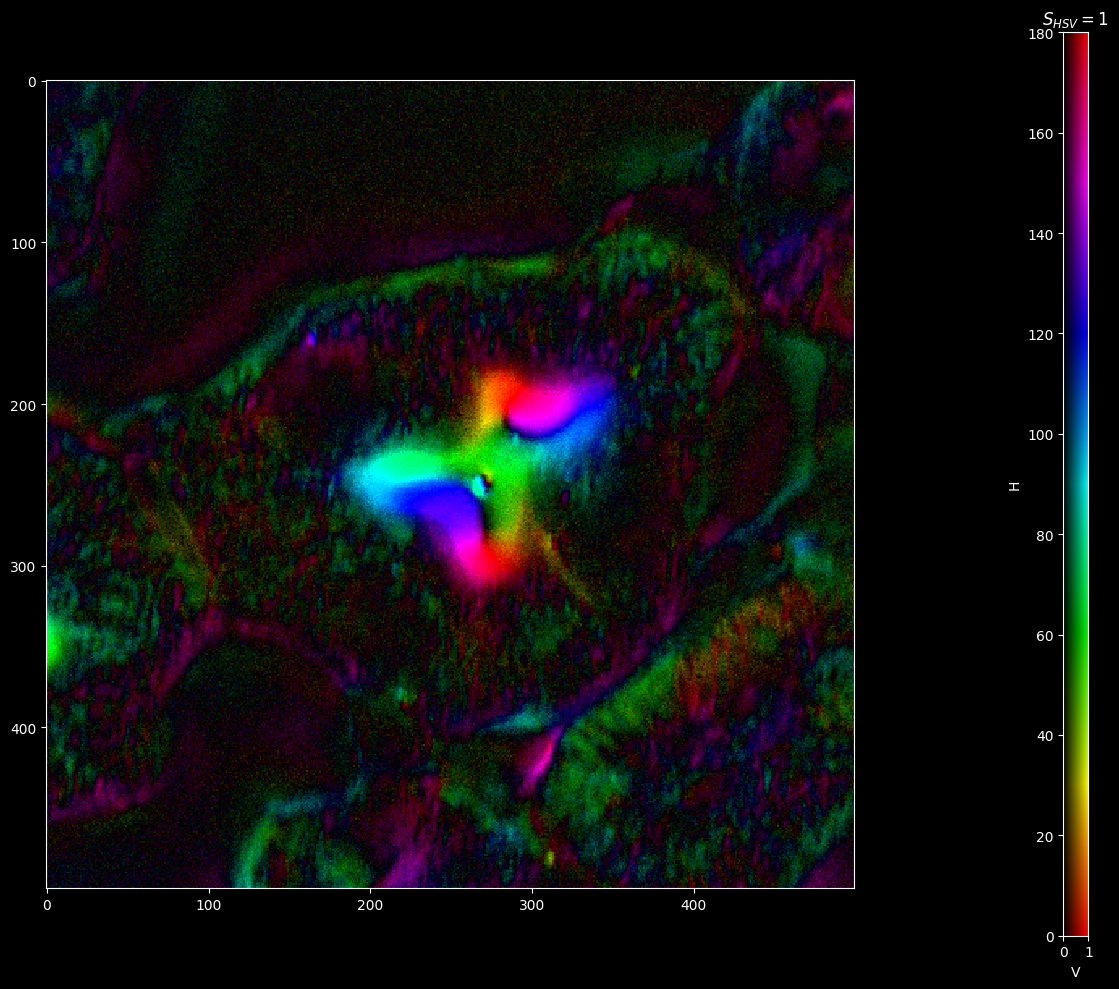

In [36]:
wo.plot_hsv(
    [Recon_para[1, :, :, 22], np.clip(Recon_para[0, :, :, 22], 0, 2 * np.pi * 5e-3 / lambda_illu)], max_val=1, size=10
)

### Phase reconstruction

In [37]:
phase = setup.Phase_recon_3D(S_image_tm[0], absorption_ratio=0.0, method="Tikhonov", reg_re=1e-4)

In [38]:
wo.image_stack_viewer(np.clip(np.transpose(phase, (2, 0, 1)), -0.08, 0.08))

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

## Birefringence reconstruction with $S_1$ and $S_2$ 

In [39]:
# The negative sign on S2 here is to compensate the sign convention in the old data format
retardance_deconv, orientation_deconv = setup.Birefringence_recon_3D(
    S_image_tm[1], -S_image_tm[2], method="Tikhonov", reg_br=30
)

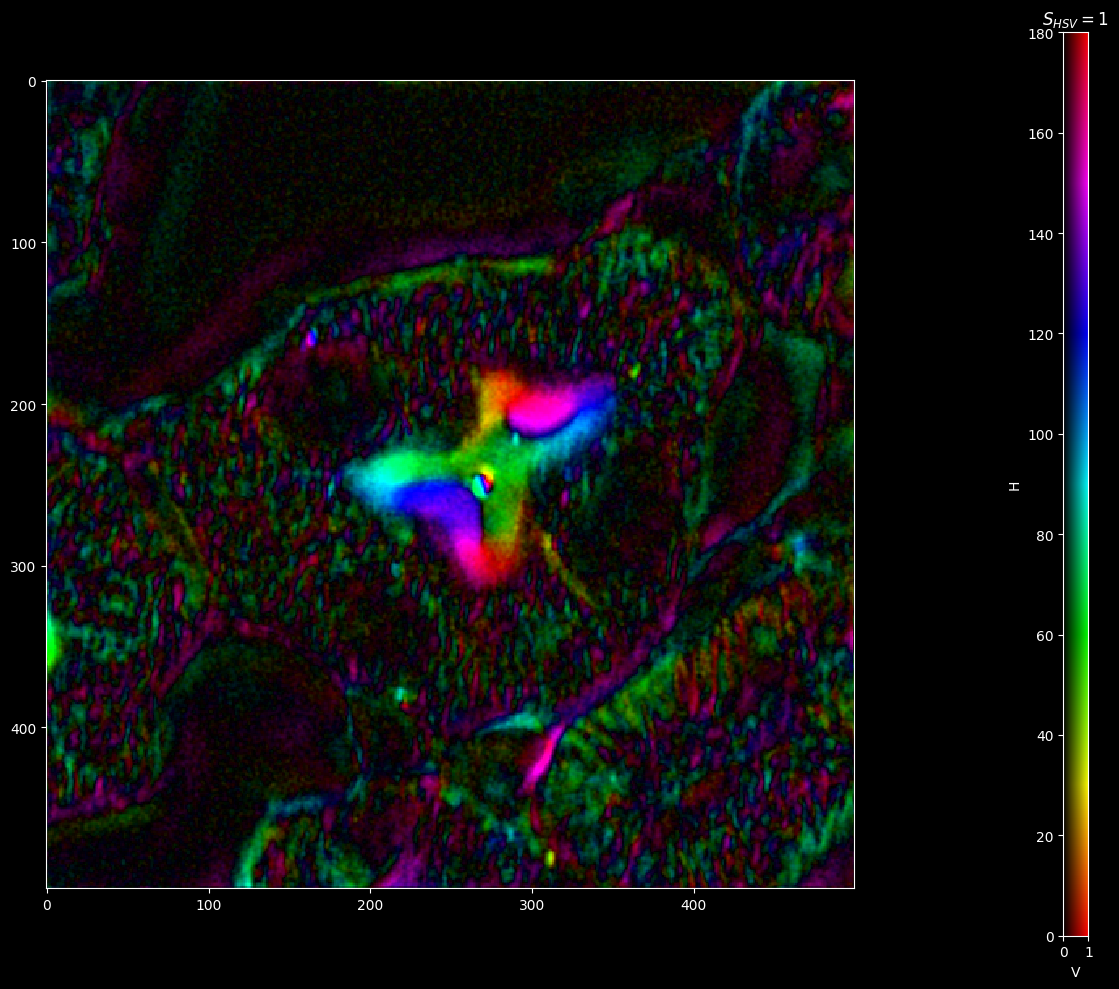

In [40]:
wo.plot_hsv([orientation_deconv[:, :, 22], retardance_deconv[:, :, 22]], max_val=0.3, size=10)

In [17]:
import gc

import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()